In [1]:
import pathlib
import platform
from IPython.display import display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from segysak.segy import segy_header_scan, segy_header_scrape, get_segy_texthead
import xarray as xr

import bruges as bg

In [2]:
nears_path = pathlib.Path("Seismic/3d_nearstack.sgy")
print("3D", nears_path, nears_path.exists())

fars_path = pathlib.Path("Seismic/3d_farstack.sgy")
print("3D", fars_path, fars_path.exists())

3D Seismic/3d_nearstack.sgy True
3D Seismic/3d_farstack.sgy True


In [3]:
# get_segy_texthead(nears_path)

In [4]:
# scan = segy_header_scan(nears_path)

# with pd.option_context("display.max_rows", 100, "display.max_columns", 10):
#     # drop byte locations where the mean is zero, these are likely empty.
#     display(scan)

In [5]:
# scan[scan["mean"] > 0]

In [6]:
# scrape = segy_header_scrape(nears_path, partial_scan=1000)
# scrape

In [7]:
nears = xr.open_dataset(
    nears_path,
    dim_byte_fields={"iline": 41, "xline": 21},
    extra_byte_fields={"cdp_x": 73, "cdp_y": 77},
)
nears = nears.rename_vars({'data' : 'nears'})

Processing Chunks:   0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

Reading header:   0%|          | 0.00/25.4k [00:00<?, ? traces/s]

In [8]:
fars = xr.open_dataset(
    fars_path,
    dim_byte_fields={"iline": 41, "xline": 21},
    extra_byte_fields={"cdp_x": 73, "cdp_y": 77},
)
fars = fars.rename_vars({'data' : 'fars'})

Processing Chunks:   0%|          | 0.00/1.00 [00:00<?, ? trace-chunks/s]

Reading header:   0%|          | 0.00/25.4k [00:00<?, ? traces/s]

In [9]:
vol = xr.merge([nears, fars], compat='override')

In [10]:
# vol = vol.rename_vars({"samples" : "twt"})


In [11]:
vol = vol.set_coords(("cdp_x", "cdp_y"))

# Inline numbering has been multiplied by 1000
vol = vol.assign_coords({"iline": (vol.iline / 1000).astype(np.int16)})
# TWT starts at 1500msTWT but loaded from 0msTWT
vol = vol.assign_coords({"samples": (vol.samples + 1500).astype(np.int16)})
# vol

In [12]:
# for grp, subds in vol.groupby("trace"):
#     print(grp)
#     print(subds)
#     break

# # dimension reduction.  can take 1 or more traces at a time...

In [13]:
vol.to_netcdf("Seismic/volume.seisnc")

# or

# vol.seisio.to_segy(
#     "Seismic/volume.segy",
#     trace_header_map={'cdp_x' : 73, "cdp_y" : 77},
#     iline=189,
#     xline=193,
# )

In [14]:
#vol["N-F"] = vol.nears - vol.fars
vol["(F-N)F"] = (vol.fars - vol.nears)*vol.fars
# vol

In [15]:
env = bg.attribute.envelope(vol.nears)
phase = bg.attribute.instantaneous_phase(vol.nears)
energy = bg.attribute.energy(vol.nears, duration=0.016, dt=0.004)
#freq = bg.attribute.instantaneous_frequency(vol.nears, dt=0.004) 
#ValueError: operands could not be broadcast together with shapes (99,251,250) (100,251,250)

In [16]:
env.shape

(101, 251, 250)

In [17]:
xlines = np.arange(1500, 2001, 2)
ilines = np.arange(1300, 1501, 2)
samples = np.arange(1500, 2500, 4)

In [18]:
ds_env = xr.Dataset(
    {
        "Env_nears": (("iline", "xline", "samples"), env)
    },
    coords={
        "iline" : ilines,
        "xline" : xlines,
        "samples" : samples
    }
)

# ds_env

In [19]:
ds_phase = xr.Dataset(
    {
        "phase": (("iline", "xline", "samples"), phase)
    },
    coords={
        "iline" : ilines,
        "xline" : xlines,
        "samples" : samples
    }
)

# ds_phase

In [20]:
# ds_freq = xr.Dataset(
#     {
#         "InstFreq": (("iline", "xline", "samples"), freq)
#     },
#     coords={
#         "iline" : ilines,
#         "xline" : xlines,
#         "samples" : samples
#     }
# )

In [22]:
vol["Envelope"] = ds_env.Env_nears
vol["Phase"] = ds_phase.phase
# vol["InstFreq"] = ds_freq.freq

In [23]:
vol

<xarray.Dataset> Size: 127MB
Dimensions:   (xline: 251, iline: 101, samples: 250)
Coordinates:
  * xline     (xline) int64 2kB 1500 1502 1504 1506 1508 ... 1994 1996 1998 2000
    cdp_x     (iline, xline) int32 101kB ...
    cdp_y     (iline, xline) int32 101kB ...
  * iline     (iline) int64 808B 1300 1302 1304 1306 ... 1494 1496 1498 1500
  * samples   (samples) int64 2kB 1500 1504 1508 1512 ... 2484 2488 2492 2496
Data variables:
    nears     (iline, xline, samples) float32 25MB 87.0 -2.478e+03 ... 32.0
    fars      (iline, xline, samples) float32 25MB ...
    (F-N)F    (iline, xline, samples) float32 25MB 1.785e+04 ... 1.227e+06
    Envelope  (iline, xline, samples) float32 25MB 964.8 2.982e+03 ... 1.175e+03
    Phase     (iline, xline, samples) float32 25MB 1.48 2.552 ... -2.489 1.544
Attributes:
    seisnc:   {"coord_scalar": 1.0, "coord_scaled": false}

Text(0.5, 0, 'XLINE')

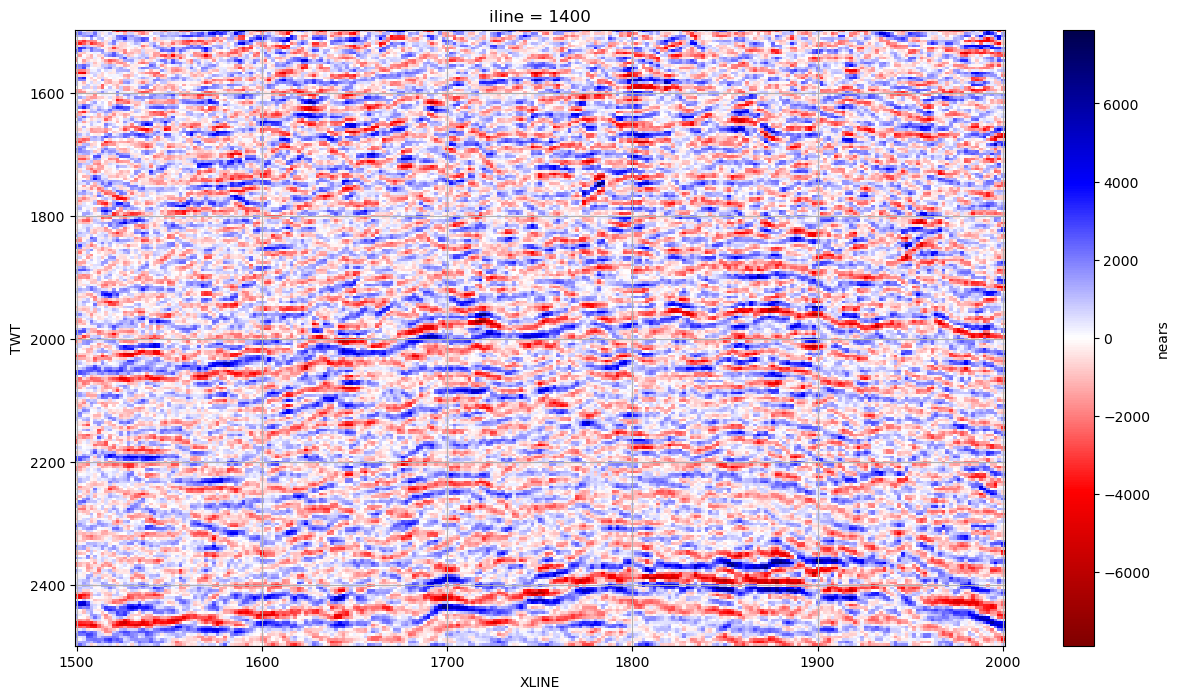

In [24]:
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
iline_sel = 1400
vol.nears.transpose("samples", "iline", "xline", transpose_coords=True).sel(
    iline=iline_sel
).plot(yincrease=False, cmap="seismic_r")
plt.grid("grey")
plt.ylabel("TWT")
plt.xlabel("XLINE")

Text(0.5, 0, 'XLINE')

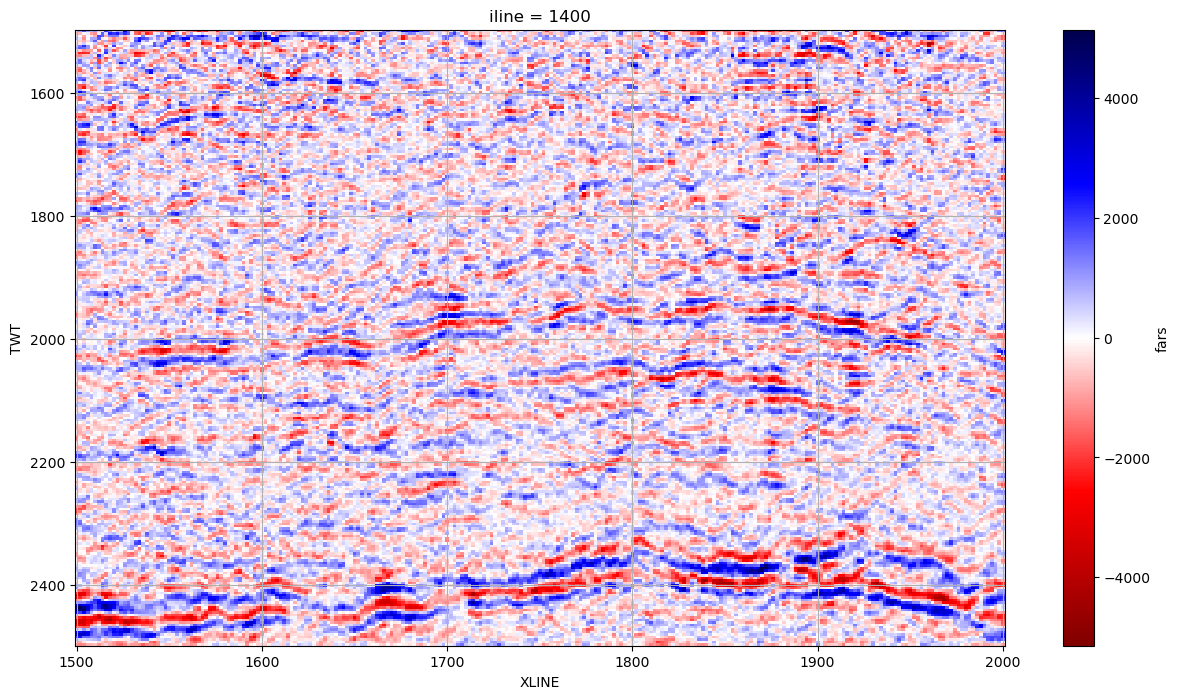

In [25]:
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
iline_sel = 1400
vol.fars.transpose("samples", "iline", "xline", transpose_coords=True).sel(
    iline=iline_sel
).plot(yincrease=False, cmap="seismic_r")
plt.grid("grey")
plt.ylabel("TWT")
plt.xlabel("XLINE")

Text(0.5, 0, 'XLINE')

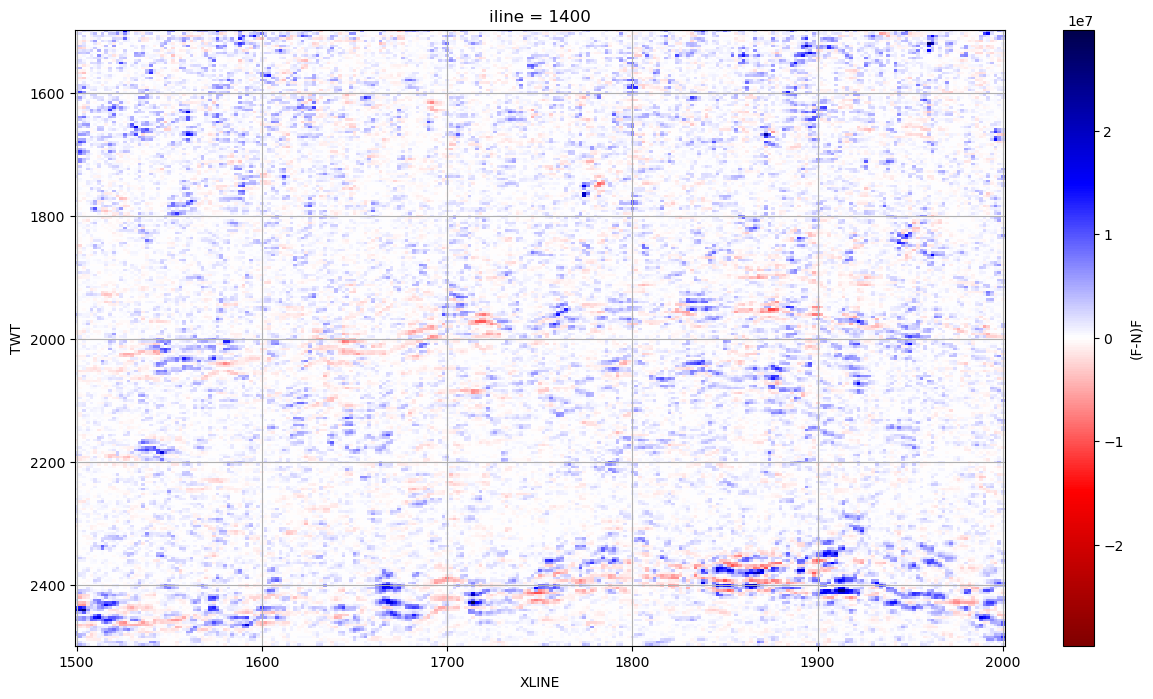

In [26]:
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
iline_sel = 1400
vol["(F-N)F"].transpose("samples", "iline", "xline", transpose_coords=True).sel(
    iline=iline_sel
).plot(yincrease=False, cmap="seismic_r")
plt.grid("grey")
plt.ylabel("TWT")
plt.xlabel("XLINE")

Text(0.5, 0, 'XLINE')

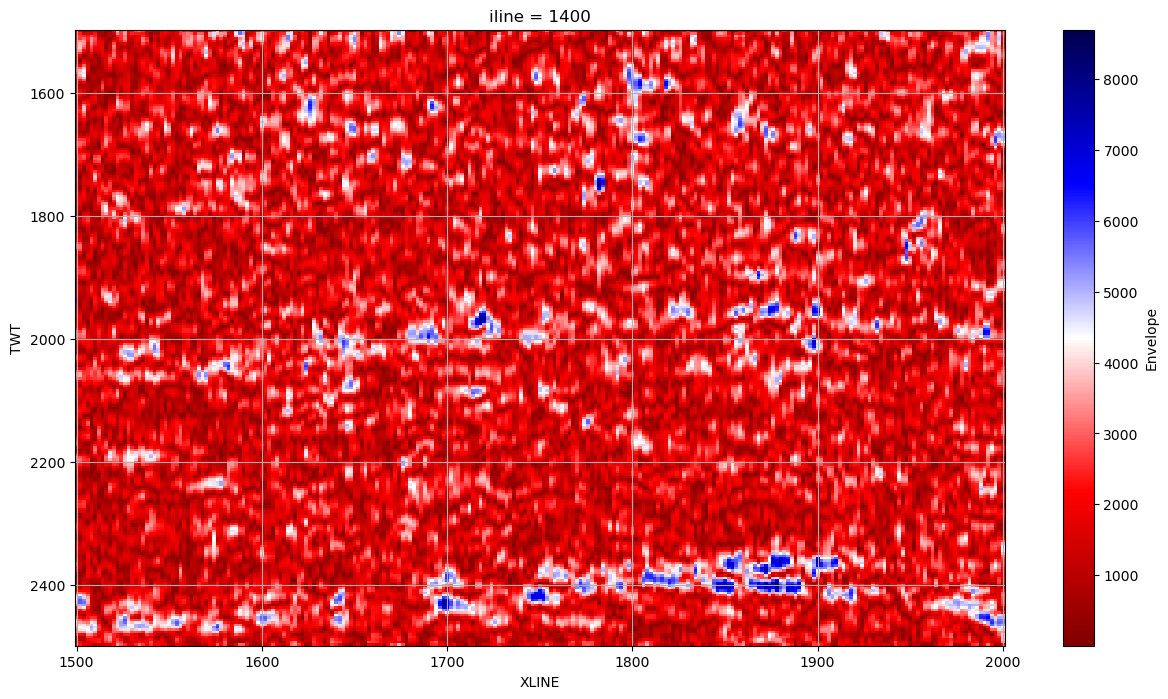

In [27]:
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
iline_sel = 1400
vol.Envelope.transpose("samples", "iline", "xline", transpose_coords=True).sel(
    iline=iline_sel
).plot(yincrease=False, cmap="seismic_r")
plt.grid("grey")
plt.ylabel("TWT")
plt.xlabel("XLINE")

Text(0.5, 0, 'XLINE')

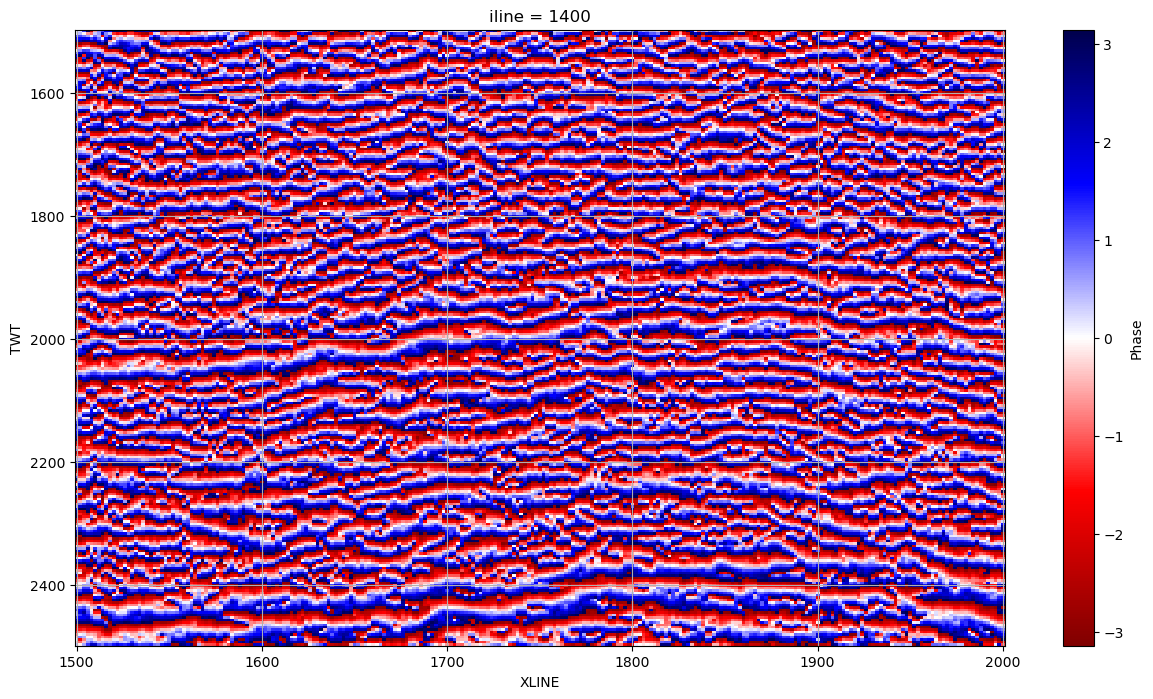

In [28]:
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
iline_sel = 1400
vol.Phase.transpose("samples", "iline", "xline", transpose_coords=True).sel(
    iline=iline_sel
).plot(yincrease=False, cmap="seismic_r")
plt.grid("grey")
plt.ylabel("TWT")
plt.xlabel("XLINE")

In [ ]:
time_sel = 550
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
vol.nears.sel(samples=time_sel, method="nearest").plot(cmap="seismic_r")
plt.title(f"Time slice at {time_sel} ms")
plt.grid(True)
plt.xlabel("XLINE")
plt.ylabel("ILINE")

In [ ]:
time_sel = 550
fig, ax1 = plt.subplots(ncols=1, figsize=(15, 8))
vol.fars.sel(samples=time_sel, method="nearest").plot(cmap="seismic_r")
plt.title(f"Time slice at {time_sel} ms")
plt.grid(True)
plt.xlabel("XLINE")
plt.ylabel("ILINE")

In [ ]:
# see 1:33:45 - Horizon flattening
vol["trace"] = (("iline", "xline"), np.arange(101*251, dtype=int).reshape(101, 251))
# vol

# vol.trace

In [ ]:
hrz_file = pathlib.Path("Horizons/Top_Heimdal_subset.txt")
hrz = pd.read_csv(hrz_file, names=["inline", "crossline", "twt"], sep="\s+")
hrz.head()

In [ ]:
cp = nears.segysak.calc_corner_points()
corners = np.array(cp)
corners

In [ ]:
from scipy.interpolate import griddata

xi = np.linspace(hrz.inline.min(), hrz.crossline.max(), 250)
yi = np.linspace(hrz.cdp_y.min(), hrz.cdp_y.max(), 250)
X, Y = np.meshgrid(xi, yi)
Z = griddata((hrz.cdp_x, hrz.cdp_y), hrz.twt, (X, Y), rescale=True)

Near and far offset partial stacks: subcubes from full 3-d cubes.
segy format

* inline: 1300-1500, every 2
* xline: 1500-2000, every 2
* time: 1500-2500 ms
* total 25351 traces for each subcube.

* xline number stored in bytes 21-26.
* inline number (multiplied by 1000) stored in bytes 41-44.

In [ ]:
# Vectorise for machine learning 
vol_df = vol.isel(iline=10).to_dataframe()
vol_df

vol_df_reindex = vol_df.reset_index()
vol_df_reindex

vol_df_multi = vol_df_reindex.set_index(["iline", "xline", "twt"])
vol_df_multi

vol_xr = vol_df_multi.to_xarray()
vol_xr

# attributes will be lost when coming back to xarray
vol_xr.attrs

vol_xr.attrs = vol.attrs
vol_xr.attrs

# cdp_x and cdp_y were broadcast to 3D.  Now collapse back to 2 dimensions
vol_xr["cdp_x"] = vol_xr["cdp_x"].mean(dim=["twt"])
vol_xr["cdp_y"] = vol_xr["cdp_y"].mean(dim=["twt"])
vol_xr = vol_xr.set_coords(["cdp_x", "cdp_y"])

vol_xr